In [1]:
!conda env list
!python -V
import sys
print(sys.executable)

# conda environments:
#
base                  *  /Applications/anaconda3
phd                      /Applications/anaconda3/envs/phd

Python 3.9.7
/Applications/anaconda3/bin/python


# Table of Contents
* [Library](#1)
    * [Model Function](#1.1)
    * [Inference Code](#1.2)
    * [Process Samples](#1.3)
    * [Plot](#1.4)
* [Murder Mystery](#2)
* [Lung](#3)

In [140]:
# DATA ANALYSIS
import numpy as np
import pandas as pd
import random as r
#from sklearn
from scipy.stats import bernoulli

# PLOTS
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# OTHERS
#import math
#import pickle

# DEBUGGER
from IPython.core.debugger import set_trace
# For executing line by line use n and 
# for step into a function use s and 
# to exit from debugging prompt use c.


# import color blind colors
colorblind = ['#377eb8', '#ff7f00', '#4daf4a',
              '#f781bf', '#a65628', '#984ea3',
              '#999999', '#e41a1c', '#dede00']

# Library <a class="anchor" id="1"></a>
## Model Function <a class="anchor" id="1.1"></a>

In [3]:
def bernoulliSample(p, valueTrue, valueFalse):
    output = {
        0: valueFalse,
        1: valueTrue,
    }
    return output.get(bernoulli.rvs(p))

def threeStatesSample(p, values):
    '''
    input: p and values as 3 elements array
    output: sampled value depending on probability distribution
    '''
    randVal = r.random()
    if (randVal < p[0]): return values[0]
    elif (randVal >= p[0] and randVal < (p[0] + p[1])): return values[1]
    else: return values[2]

## Inference Code <a class="anchor" id="1.2"></a>
Creates a *rejection sampler*. Samples from a dist. Rejects the samples that do not match obs, accepts samples that match it

In [46]:
def inferenceCode(modelToRun, processData, obs, obs_label, n_samples = 10000):
    '''
    modelToRun: model function name
    obs: inference query dict
    obs_label: observation label for graph
    '''
    samples = []
    n_iter = 0
    
    # create joint samples
    while(len(samples) < n_samples):
        sample = modelToRun()
        n_match = 0
        n_iter += 1
        # check how many keys in common
        for key in obs.keys():
            if (sample[key] == obs[key]): 
                n_match += 1
        # save sample if all key match
        if (n_match == len(obs)): samples.append(sample)
    print(n_iter,'iterations performed to get', n_samples, 'samples matching the following inference query:', obs)

    # process data
    cleanedData = processData(samples, obs_label)
    return cleanedData

## Process samples <a class="anchor" id="1.3"></a>
The samples are processed to compute the probability of the analysed event.


In [104]:
def processData(samples, obs_label):
    '''
    obs_label: observation label
    '''

    # find the first key of a sample
    first_key = next(iter(samples[0]))
    
    m = []
    for sample in samples:
        m.append(sample[first_key])
        
    # create data frame with output
    df = pd.Series(m, name = 'Count').value_counts()

    df = df.reset_index().rename(columns={'index':first_key})
    # normalise counts to [0,1]
    df["P(" + first_key + ")"] = df["Count"].apply(lambda x: x/df["Count"].sum())
    # add category 
    df['Label'] = obs_label
    return df

# Plot <a class="anchor" id="1.4"></a>

In [174]:
def plotFigure(df, height=400, width=700):
    # The first column of the df should have the event name
    event = df.columns[0]
    fig = px.bar(df,
                 x="Label",
                 y="P(" + event + ")",
                 color=event,
                 #barmode="group",
                 title="P(" + event + " for various inference queries",
                 width=width,
                 height=height)
    fig.update_layout(
        font_color="black",
        font_size=9,
        title_font_size=14
    )
    return fig.show()

# Murder Mystery <a class="anchor" id="2"></a>
The model outputs three variables
- `murderer`: Grey or Auburn
- `weapon`: revolver or dagger
- `hair`: true or false

The probability of success for the Benoulli trial for the variables `weapon` and `hair` are conditionnaly dependent on the outcome of `murderer`

Definitions:
- random variate: particular outcome of a random variable

Functions:
- `bernoulli.rvs(p)`: generates a random variates for a randome variable following a Bernoulli distribution of probability p

In [5]:
# Model Function
def murderMysteryModel():
    murderer = bernoulliSample(0.7, "Auburn", "Grey")
    revolver_p = {
        "Grey": 0.9,
        "Auburn": 0.2
    }
    weapon = bernoulliSample(revolver_p.get(murderer), "revolver", "dagger")
    hair_p = {
        "Grey": 0.5,
        "Auburn": 0.05
    }
    hair = bernoulliSample(hair_p.get(murderer), True, False)
    return {
        "murderer" : murderer,
        "weapon" : weapon,
        "hair" : hair
    }
# 1 sample for the murder mystery model
murderMysteryModel()

{'murderer': 'Auburn', 'weapon': 'dagger', 'hair': False}

In [124]:
# Rejection sampler for 4 observations
m = inferenceCode(murderMysteryModel,
                  processData,
                  {}, 
                  'Prior')
mw = inferenceCode(murderMysteryModel,
                  processData,
                  {'weapon': 'revolver'}, 
                   'After observing weapon')
mh = inferenceCode(murderMysteryModel,
                  processData,
                  {'hair': True}, 
                   'After observing hair')
mwh = inferenceCode(murderMysteryModel,
                  processData,
                  {'weapon': 'revolver', 'hair': True}, 
                   'After observing weapon and hair')
# concatenate
murderers = pd.concat([m, mw, mh, mwh])
murderers

10000 iterations performed to get 10000 samples matching the following inference query: {}
24508 iterations performed to get 10000 samples matching the following inference query: {'weapon': 'revolver'}
54302 iterations performed to get 10000 samples matching the following inference query: {'hair': True}
69294 iterations performed to get 10000 samples matching the following inference query: {'weapon': 'revolver', 'hair': True}


,murderer,Count,P(murderer),Label
0,Auburn,6984,0.6984,Prior
1,Grey,3016,0.3016,Prior
0,Grey,6652,0.6652,After observing weapon
1,Auburn,3348,0.3348,After observing weapon
0,Grey,8109,0.8109,After observing hair
1,Auburn,1891,0.1891,After observing hair
0,Grey,9545,0.9545,After observing weapon and hair
1,Auburn,455,0.0455,After observing weapon and hair


In [125]:
# Plot results
plotFigure(murderers)

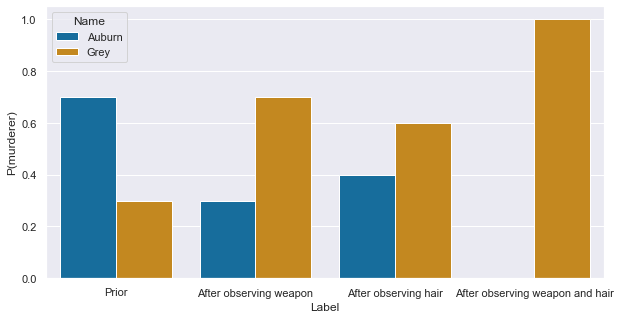

In [11]:
f = plt.figure(figsize=(10,5))
sns.set_theme(style="darkgrid",palette="colorblind")
sns.barplot(x="Label", 
            y="P(murderer)", 
            hue="Name", 
            data=murderers)
plt.show()

## Lung <a class="anchor" id="3"></a>


In [137]:
# Lunf Function Model
def lungModel():
    inflammation = threeStatesSample([0.3, 0.5, 0.2], ["absent", "small", "heavy"])
    
    FEV1_p = {
        "absent": [0.6, 0.3, 0.1],
        "small": [0.3, 0.3, 0.4],
        "heavy": [0.1, 0.3, 0.6]
    }
    FEV1 = threeStatesSample(FEV1_p.get(inflammation), ["stable", "sligth_drop", "heavy_drop"])
    
    cough_p = {
        "absent": 0.8,
        "small": 0.5,
        "heavy": 0.3
    }
    cough = bernoulliSample(cough_p.get(inflammation), "normal", "high")
    
    bacterial_load_p = {
        "stable": [0.6, 0.3, 0.1],
        "sligth_drop": [0.3, 0.4, 0.3],
        "heavy_drop": [0.1, 0.5, 0.5]
    }
    
    bacterial_load = threeStatesSample(bacterial_load_p.get(FEV1), ["low", "medium", "high"])
    
    return {
        "Inflammation" : inflammation,
        "FEV1" : FEV1,
        "Cough" : cough,
        "Bacterial load" : bacterial_load
    }
lungModel()

{'Inflammation': 'heavy',
 'FEV1': 'sligth_drop',
 'Cough': 'high',
 'Bacterial load': 'low'}

In [162]:
FEV1 = inferenceCode(lungModel, processData, 
              {'FEV1': 'stable'}, 
              'After observing FEV1')

28537 iterations performed to get 10000 samples matching the following inference query: {'FEV1': 'stable'}


,Inflammation,Count,P(Inflammation),Label
0,absent,5160,0.5160,After observing FEV1
1,small,4296,0.4296,After observing FEV1
2,heavy,544,0.0544,After observing FEV1


In [164]:
inferenceCode(lungModel, processData, 
              {'FEV1': 'stable', 'Bacterial load': 'medium'}, 
              'After observing FEV1 and Bacterial load',
             n_samples = 100000)

951859 iterations performed to get 100000 samples matching the following inference query: {'FEV1': 'stable', 'Bacterial load': 'medium'}


,Inflammation,Count,P(Inflammation),Label
0,absent,51148,0.51148,After observing FEV1 and Bacterial load
1,small,43205,0.43205,After observing FEV1 and Bacterial load
2,heavy,5647,0.05647,After observing FEV1 and Bacterial load


In [178]:
# Create a rejection sampler for 4 observations
prior = inferenceCode(lungModel, processData, 
              {}, 
              'Prior')
cough = inferenceCode(lungModel, processData, 
              {'Cough': 'normal'}, 
              'After observing cough')
volume_cough = inferenceCode(lungModel, processData, 
              {'FEV1': 'stable', 'Cough': 'high'}, 
              'After observing FEV1')
load = inferenceCode(lungModel, processData, 
              {'FEV1': 'stable', 'Cough': 'high', 'Bacterial load': 'medium'}, 
              'After observing FEV1, bacterial load')

inflammation = pd.concat([prior, cough, volume_cough, load])
inflammation

10000 iterations performed to get 10000 samples matching the following inference query: {}
18287 iterations performed to get 10000 samples matching the following inference query: {'Cough': 'normal'}
28696 iterations performed to get 10000 samples matching the following inference query: {'FEV1': 'stable'}
95740 iterations performed to get 10000 samples matching the following inference query: {'FEV1': 'stable', 'Bacterial load': 'medium'}


,Inflammation,Count,P(Inflammation),Label
0,small,4987,0.4987,Prior
1,absent,3017,0.3017,Prior
2,heavy,1996,0.1996,Prior
0,small,4550,0.4550,After observing cough
1,absent,4346,0.4346,After observing cough
2,heavy,1104,0.1104,After observing cough
0,absent,5160,0.5160,After observing FEV1
1,small,4248,0.4248,After observing FEV1
2,heavy,592,0.0592,After observing FEV1
0,absent,5211,0.5211,"After observing FEV1, bacterial load"


In [179]:
# Plot results
plotFigure(inflammation, height=500)